Matthew Morgan
Student ID: 010471280
D213 - Advanced Data Analytics
Task 1: Time Series Modeling
Western Governor's University
Mentor: Mandy Rasmuson

Part I: Research Question

A.  Describe the purpose of this data analysis by doing the following:

A1.  Summarize one research question that is relevant to a real-world organizational situation captured in the selected data set and that you will answer using time series modeling techniques.

The research question I am hoping to answer in this report is, "Can I build a model that will forecast what our revenue could be for the next quarter?"

A2.  Define the objectives or goals of the data analysis. Ensure your objectives or goals are reasonable within the scope of the scenario and are represented in the available data.

The goal of this analysis is to build a predictive model that can forecast the revenue of the upcoming quarter based on the overall trends and seasonality of the past two years.

Part II: Method Justification

B.  Summarize the assumptions of a time series model including stationarity and autocorrelated data.

The assumptions of a time series model are as follows:

1. Time series data should be stationary.

- This means the series is normally distributed and the mean variance are constant over that period of time. The series has zero trends, it is not growing or shrinking. The variance and autocorrelation are constant (Datacamp, n.d).

2. The error term is randomly distributed, and the mean and the variance are constant over a time period. The error in time series analysis is assumed to be uncorrelated.

3. There should be no outliers in the series. Outliers could lead to inaccurate results (Statistics Solutions, 2021).

4. The residuals aren't autocorrelated.

Stationarity: is an assumption in Time Series that the mean, variance, and autocorrelation structure do not change over time (sematech, Sangarshanan, 2018). It means that the distribution of the data does not change with time. For Time Series to be stationary it must fulfill these three criteria:
1. The series has zero trends, it is not growing or shrinking.
2. The variance is constant. 
3. The autocorrelation is constant. How each value in the time series is related to its neighbors stay the same (Datacamp, n.d).

Autocorrelation is a mathematical representation of the degree of similarity between a given time series and a lagged ersion of iftself over successive time intervals. Autocorrelation measures a set of current values against a set of past values to see if they correlate (Elleh, 2022). Also means that future values can be predicted as a linear function of past values. In time series each obseravtion called a lag could correlate its prior lags.

Part III: Data Preparation

C.  Summarize the data cleaning process by doing the following:
C1.  Provide a line graph visualizing the realization of the time series.

In [1]:
# Data Analytics imports
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Visualization imports
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Model imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_predict

import warnings
warnings.filterwarnings('ignore')

#Loading the CSV of the default dataset
df = pd.read_csv(r'C:\Users\mmorg\WGU\D213\Task 1\medical_time_series.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.5 KB


In [2]:
#Detect null values
print(df.isnull().sum())

Day        0
Revenue    0
dtype: int64


In [3]:
# Look at what type of data is in each column and the name of the columns
df.head()

,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888


In [4]:
# Look at size of data
df.shape

(731, 2)

In [5]:
# Look at dataframe
df

,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888
...,...,...
726,727,15.722056
727,728,15.865822
728,729,15.708988
729,730,15.822867


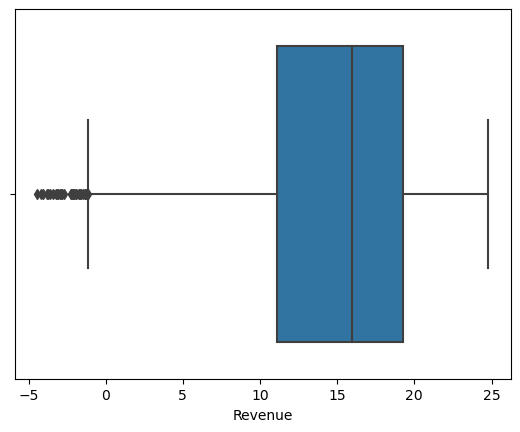

In [6]:
# Checking for outliers
boxplot=sns.boxplot(x='Revenue',data=df)
plt.show()

In [7]:
# Set start date for dataset
start_date = pd.to_datetime('2019-01-01')
# Day to Date conversion
df['Day'] = pd.to_timedelta(df['Day']-1, unit='D') + start_date
# Renaming Day to date, and Revenue to revenue so names make more sense and capitalization doesn't matter
df.columns = ['date', 'revenue']
# Set date as index
df.set_index('date', inplace=True)
# Display dataframe
df

,revenue
date,
2019-01-01,0.000000
2019-01-02,-0.292356
2019-01-03,-0.327772
2019-01-04,-0.339987
2019-01-05,-0.124888
...,...
2020-12-27,15.722056
2020-12-28,15.865822
2020-12-29,15.708988


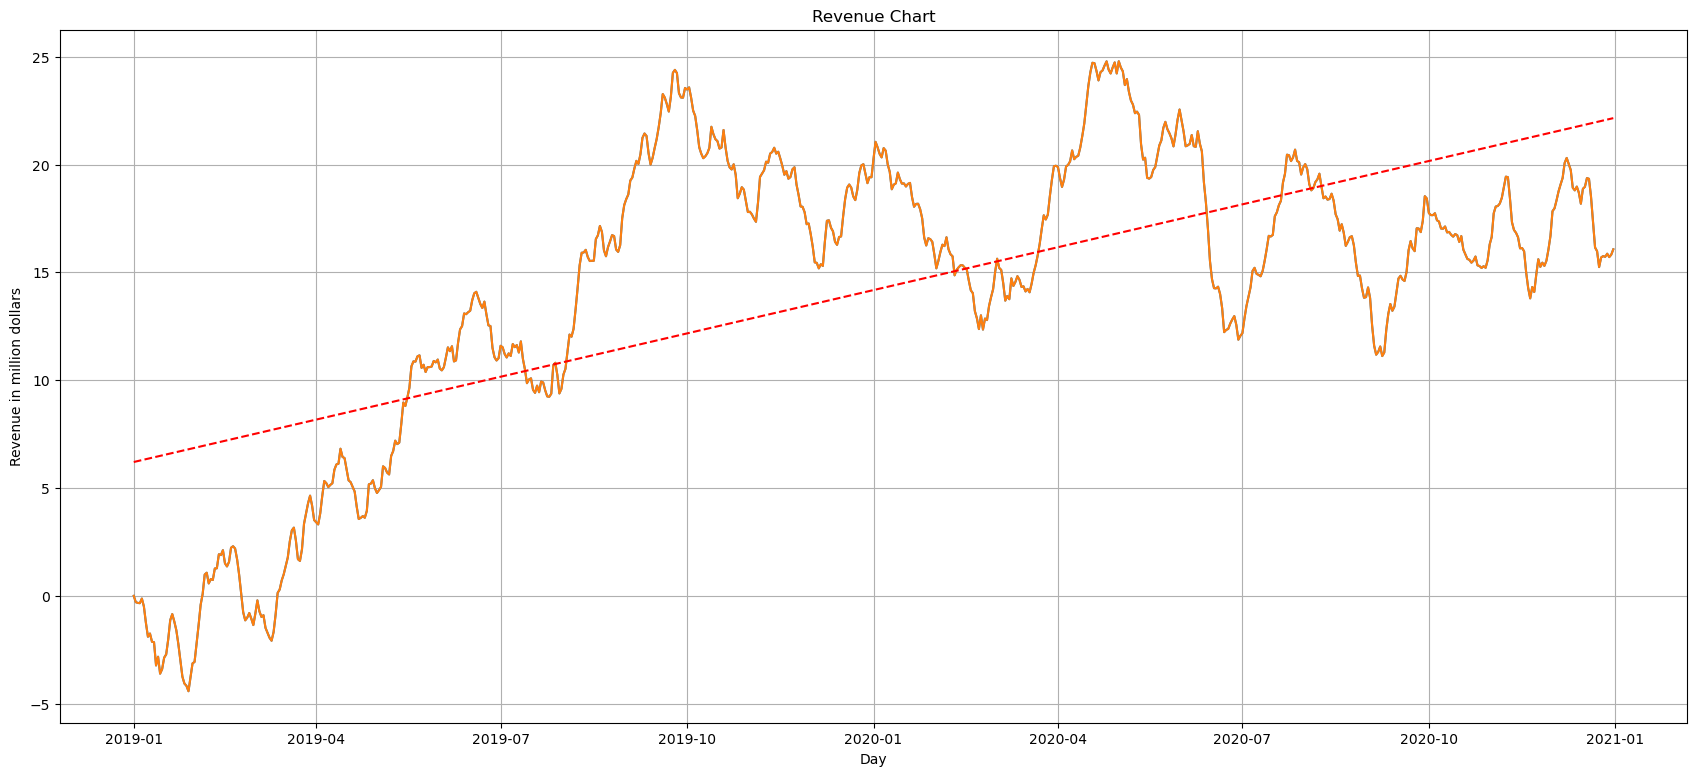

In [8]:
# Create line plot
plt.figure(figsize = [21, 9])
plt.plot(df.revenue)
plt.xlabel('Day')
plt.ylabel('Revenue in million dollars')
plt.title('Revenue Chart')
plt.grid(True)
plt.plot(df)
# Generate Trend Line
x = mdates.date2num(df.index)
y = df.revenue
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
# Plot Trend Line
plt.plot(x, p(x), "r--")
plt.show()

C2.  Describe the time step formatting of the realization, including any gaps in measurement and the length of the sequence.

The time series shows DateTime corresponding with that days revenue in millions of dollars (USD) for the WGU Hospital. After the earlier conversion the time step formatting is advancing forward a day at a time starting on 2019-01-01. The sequence is 731 days long and the dataset covers all dates from 2019-01-01 to 2020-12-31 which equates to two years with no days of absent data. Because of the earlier DateTime conversion we have more flexibility to perform further analysis by aggregating data in different chunks such as by week, month, or year. 

C3.  Evaluate the stationarity of the time series.

This dataset does not display stationarity as a stationarity time series does not have a trend. This is confirmed by using an Augmented Dickey-Fuller test below. In this case, our null hypothesis would be that it is non-stationary. Our p-value is large, and therefore we fail to reject the null hypothesis.

In [9]:
# Running Dickey-Fuller test to check test statistic, p-value, and critical values
result = adfuller(df['revenue'])
print("Test statistics: ", result[0])
print("p-value: ", result[1])
print("Critical values: ", result[4])

Test statistics:  -2.218319047608945
p-value:  0.19966400615064372
Critical values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [10]:
# Evaluating p-value
if result[1]<= 0.05:
    print("Reject null hypothesis, the time series is stationary")
else:
    print("Fail to reject null hypothesis, the time series is non-stationary")

Fail to reject null hypothesis, the time series is non-stationary


C4.  Explain the steps you used to prepare the data for analysis, including the training and test set split.

Recapping what we have done so far:
1. Import data from csv into pandas dataframe
2. Perform EDA to visualize shape of data (731, 2) and identify null values (no nulls). 
3. Convert day column to DateTime.
4. Rename Day to date, and Revenue to revenue.
5. Set date column as index.

What we will do next based on failure to reject null hypothesis:
6. Differencing the data into a stationary time series to meet assumptions mentioned in section B.
7. Split observed data into train/test splits. 

In [11]:
# Use diff() method to to take difference of each successive data point, drop new null created in row 1
df_diff = df.diff().dropna()
# Perform augmented Dickey-fuller
aug_adfuller = adfuller(df_diff.revenue)
# Print new Dickey-fuller results
trans_result = aug_adfuller
print("Test statistics: ", round(trans_result[0], 5))
print("p-value: ", round(trans_result[1], 5))

Test statistics:  -17.37477
p-value:  0.0


Our time series has been successfully differenced, and we can now reject the null hypothesis from before. Because it only needed to be differenced one time, therefore the d for our ARIMA model will be 1.

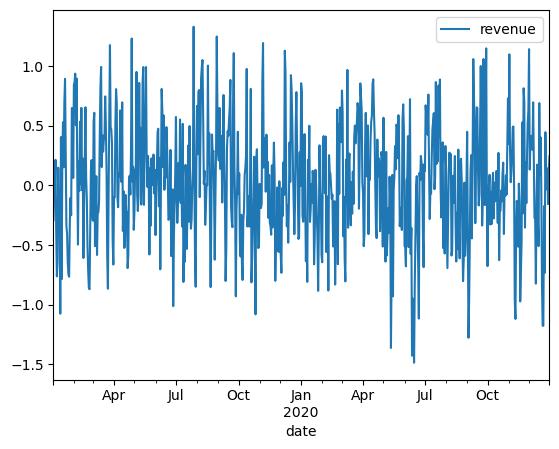

In [12]:
# Create plot to verify
df_diff.plot();

In [13]:
# use last 146 days (20%) for testing
df_train = df.iloc[1:-146]
df_test = df.iloc[-146:]
print('training: {}'.format(df_train.shape))
print('testing: {}'.format(df_test.shape))

training: (584, 1)
testing: (146, 1)


In [14]:
#C5.  Provide a copy of the cleaned data set.

df_diff.to_csv(r'C:\Users\mmorg\WGU\D213\Task 1\CleanedTask1Data.csv')
df_train.to_csv(r'C:\Users\mmorg\WGU\D213\Task 1\Task1TrainSet.csv')
df_test.to_csv(r'C:\Users\mmorg\WGU\D213\Task 1\Task1TestSet.csv')

Part IV: Model Identification and Analysis

D.  Analyze the time series data set by doing the following:

D1.  Report the annotated findings with visualizations of your data analysis, including the following elements:

##The presence or lack of a seasonal component

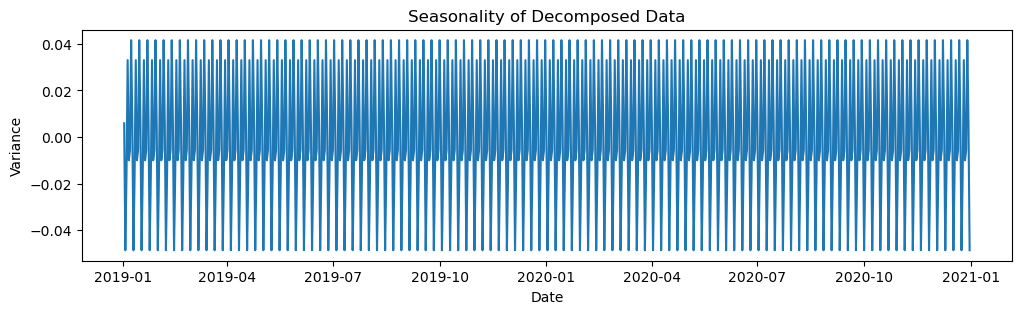

In [15]:
# Plot seasonality
decomp_data = seasonal_decompose(df_diff)
plt.figure(figsize = [12, 3])
plt.title('Seasonality of Decomposed Data')
plt.ylabel('Variance')
plt.xlabel('Date')
plt.plot(decomp_data.seasonal)

Seasonality refers to cycles that repeat regularly over time as shown above. This cycle looks to repeat at the same frequency so I decided to zoom in below to see if we can spot recurring patterns at a smaller scale.

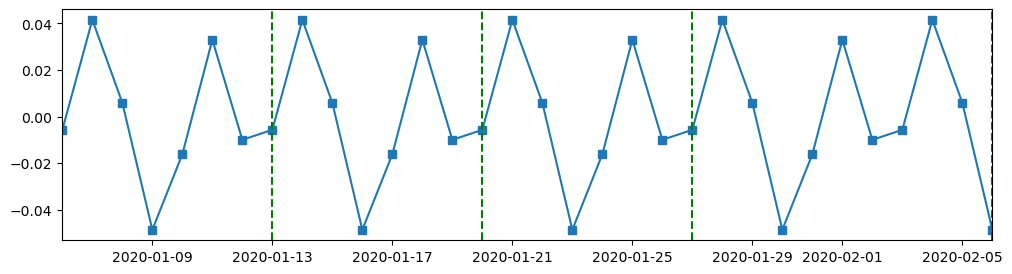

In [16]:
# Make graph wider for visibility
plt.figure(figsize = [12,3])
# Plot seasonal decomp_data
plt.plot(decomp_data.seasonal, marker='s')
plt.xlim(pd.to_datetime('2020-01-06'), pd.to_datetime('2020-02-06'))
# Mark off Mondays with dashed green lines
plt.axvline(x=pd.to_datetime('2020-01-13'), color='green', linestyle='--')
plt.axvline(x=pd.to_datetime('2020-01-20'), color='green', linestyle='--')
plt.axvline(x=pd.to_datetime('2020-01-27'), color='green', linestyle='--')
plt.axvline(x=pd.to_datetime('2020-02-06'), color='green', linestyle='--');

This is a plot that shows the weeks from 2020-01-06 to 2020-02-06 with red lines occuring on Mondays. This allows us to see that the values peak on Tuesdays and Saturdays each week. There are also two troughs each week occuring on Thursdays and Sundays.

Compared to the overall dataset the impact of seasonality seems very small. As said earlier the range here is from 0.04 to -0.04 whereas the overall magnitude of the dataset is 1.0 - 1.5. Because of this I don't feel that it needs to be addressed any further.

##Trends

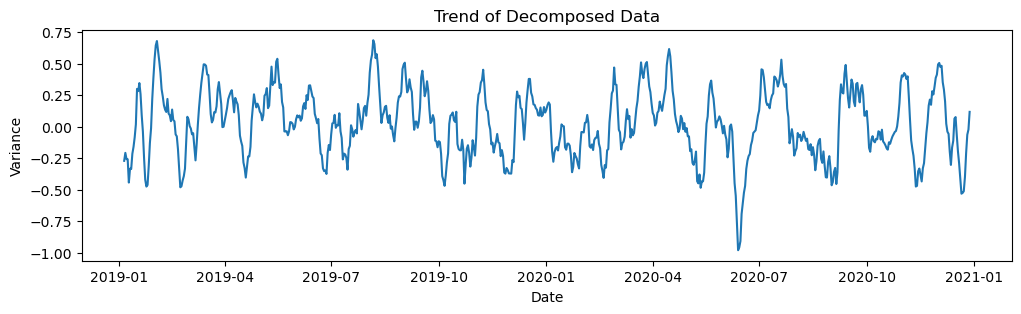

In [17]:
# Trend plot of decomp_data
plt.figure(figsize = [12, 3])
plt.title('Trend of Decomposed Data')
plt.ylabel('Variance')
plt.xlabel('Date')
plt.plot(decomp_data.trend)

A trend of a time series can be determined by analyzing the overall direction of the series over a period. It can be upward or downward. This trend plot shows that there is no obvious trend that jumps out. The only thing of note is the possible outlier around June of 2020. 

##The autocorrelation function

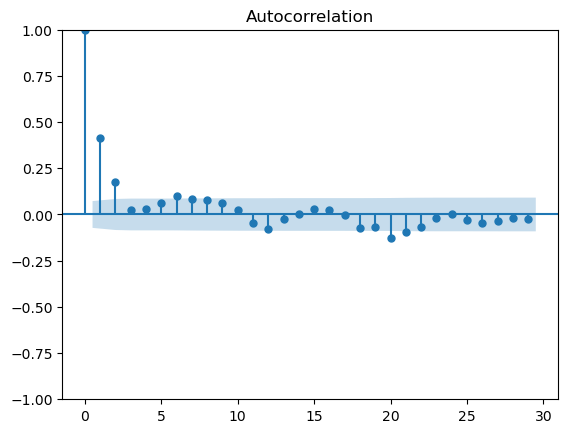

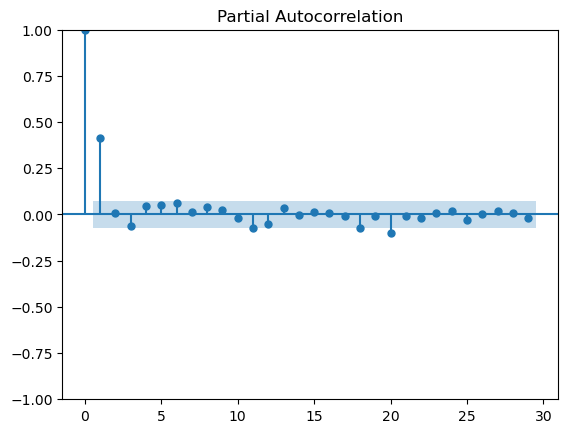

In [21]:
# Autocorrelation plot of df_train_diff
acf_diff = plot_acf(df_diff)

# Partial Autocorrelation plot of df_train_diff
pacf_diff = plot_pacf(df_diff)

Autocorrelation (ACF) is a plot of the how the data is correlating across time periods. A vlue between 0 and 1 represents a positive correlation, whereas negative values would denote that the data is not correlated.

Partial autocorrelation (PACF) is the correlation between a time series and the lagged version of itself after we subtract the effect of correlation at smaller lags. 

The ACF shows values in and outside of the blue region. The points inside the blue region are considered statistically insignificant. The ACF cuts off after 2 while the PACF cuts off after 1. This provides us with our p (1) and q (2) values for our ARIMA model. 

##The spectral density

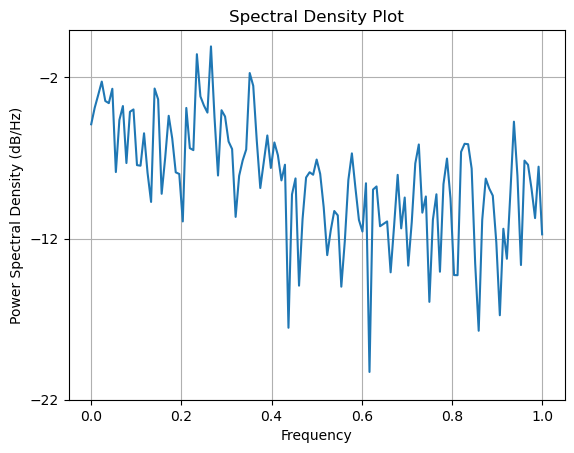

In [92]:
# Spectral Density Plot
plt.psd(x=df_diff.revenue)
plt.title('Spectral Density Plot');

The above plot is the power spectral density of the differenced time series. 

##The decomposed time series

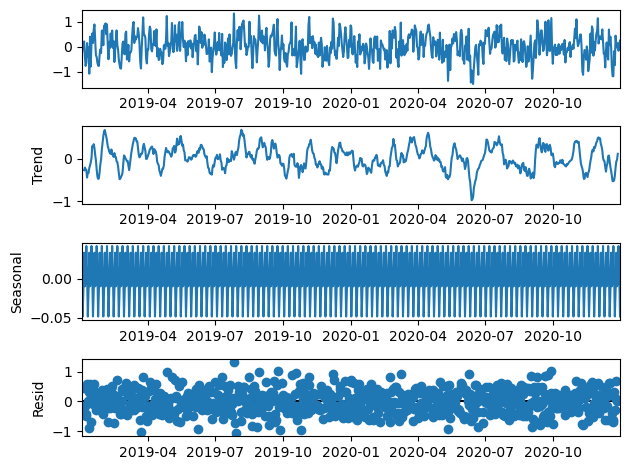

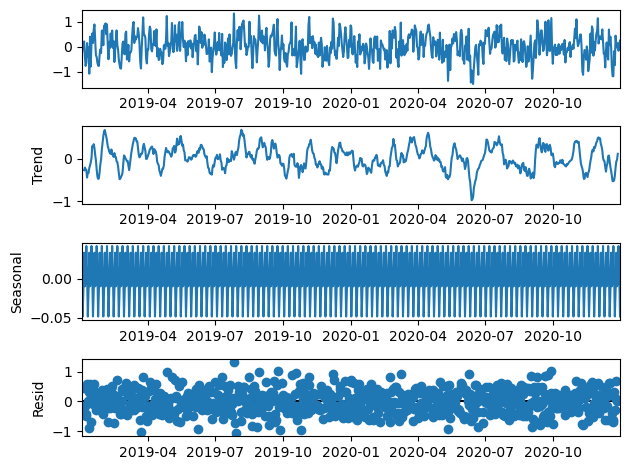

In [93]:
# Creating decomposed time series
decomp_data.plot()

The decomposed time series showing tends, seasonality, and residuals. 

##Confirmation of the lack of trends in the residuals of the decomposed series

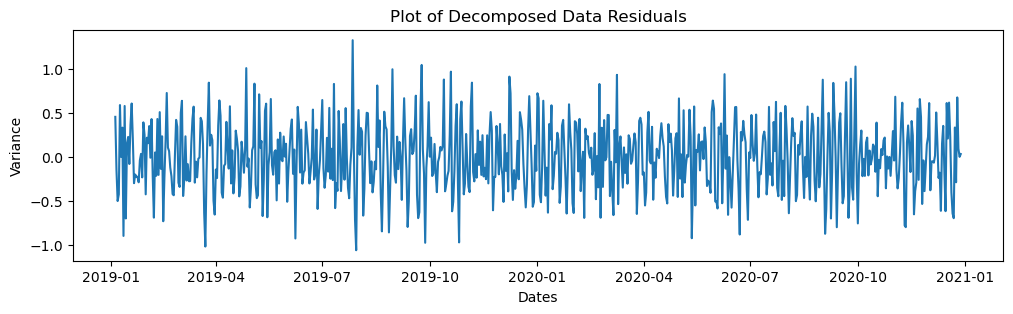

In [94]:
# Widen graph
plt.figure(figsize = [12,3])
# Plot residual component
plt.title('Plot of Decomposed Data Residuals')
plt.xlabel('Dates')
plt.ylabel('Variance')
plt.plot(decomp_data.resid);

After plotting the residuals of the decomposed time series it appears that there are no obvious trends in this visualization. 

D2.  Identify an autoregressive integrated moving average (ARIMA) model that accounts for the observed trend and seasonality of the time series data.

In [95]:
# Run ARIMA model based already established p, d, q values
model = ARIMA(df_train, order=(1,1,2))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                  584
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -347.560
Date:                Sat, 01 Jul 2023   AIC                            703.120
Time:                        22:33:45   BIC                            720.592
Sample:                    01-02-2019   HQIC                           709.930
                         - 08-07-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1267      0.182      0.697      0.486      -0.229       0.483
ma.L1          0.2735      0.179      1.528      0.127      -0.077       0.624
ma.L2          0.1853      0.070      2.643      0.0

D3.  Perform a forecast using the derived ARIMA model identified in part D2.

Now that we've produced predictions from our ARIMA model we have to verify the data. I will start by checking the residuals and density.

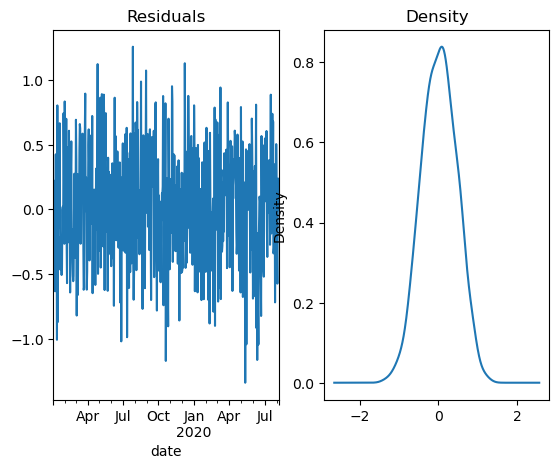

In [96]:
# Plot residuals and density
residuals = results.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

The residuals look random and the density looks evenly distributed with a mean of 0. This means our data is distributed in a way that allows us to produce a forecast. Now I will plot the forecast vs revenue.

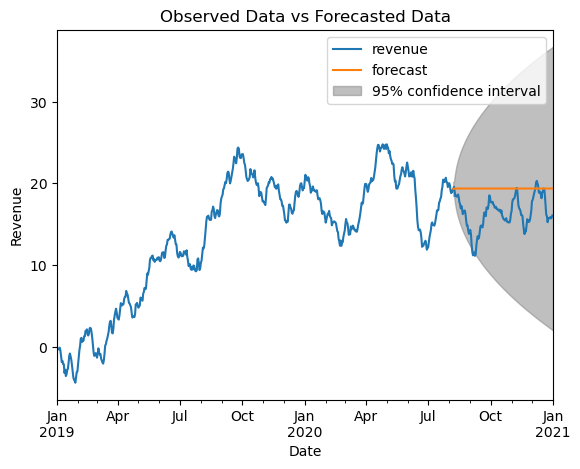

In [97]:
# Observed Data vs Forecasted Data
fig, ax = plt.subplots()
df['revenue'].plot(ax=ax)
plot_predict(results, start=583, end=730, ax=ax)
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.title('Observed Data vs Forecasted Data')
plt.show()

In [98]:
# Calculate root mean squared error of forecasted data against the observed data (both untransformed)
predictions = results.predict(start = 585, end = 730, type='levels')
rmse = mean_squared_error(df_test, predictions, squared=False)
print(f"The root mean squared error of this forecasting model is {round(rmse, 5)}")

The root mean squared error of this forecasting model is 3.56547


D4.  Provide the output and calculations of the analysis you performed.

Provided above.

D5.  Provide the code used to support the implementation of the time series model.

Provided above.

Part V: Data Summary and Implications

E.  Summarize your findings and assumptions by doing the following:

E1. Discuss the results of your data analysis, including the following points:

•   the selection of an ARIMA model

In real life I would run two separate models. The first model being an auto_arima and the model that I ran with values that I chose based on the order of differencing (d = 1), Partial Autocorrelation (p = 1), and Autocorrelation (q = 2). This would alter the predictions and I would then have two working models to compare to each other and determine which one to go with. I am only doing one model due to doing my best to follow the rubric and make it easier to justify my model selection.

•   the prediction interval of the forecast
•   a justification of the forecast length

The prediction interval of my forecast is 1 day. The forecast length was decided because of using an 80/20 train/test split with my data. 20% of the data constitutes a prediction interval of 146 steps. I chose to go with the 80/20 split for two reasons. The first being I wanted a large amount of data for my train set. Secondly, I wanted to forecast the least amount of time possible. Dr. Elleh's lecture recommeneded only forecasting 30 to 60 days. However, to created a train/test split I don't want to go outside the ranges of 70/30 or 80/20. Therefore, I chose the split that would result in the least amount of days forecasted. 

•   the model evaluation procedure and error metric

I evaluated the model by using the root mean squared error. My model produced an RMSE of 3.56547. If I did run a second model as mentioned earlier in this section, I would be able to compare the RMSE of each model. The lower the number the better. As I don't have anything to compare this to I can't really comment on how well this model performed.

E2.  Provide an annotated visualization of the forecast of the final model compared to the test set.

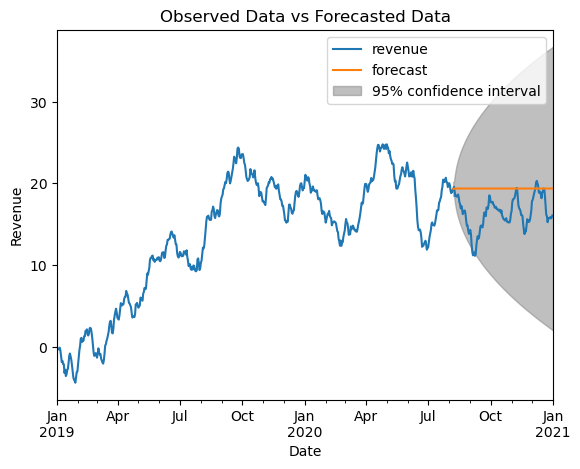

In [99]:
# Observed Data vs Forecasted Data
fig, ax = plt.subplots()
df['revenue'].plot(ax=ax)
plot_predict(results, start=583, end=730, ax=ax)
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.title('Observed Data vs Forecasted Data')
plt.show()

E3.  Recommend a course of action based on your results.

Since I am not sure if my model is very accurate or not as I have nothing to compare it to I am going to make recommendations as if my model has been thoroughly reviewed and determined to be a strong model to move forward with.

This forecast has shown the ability to predict about 2 quarters worth or revenue (146 days). Because of this we can use this model to forecast with a prediction interval of 1 day and a forecast length of 90-180 days though shorter forecasts are always more accurate. The company can use this forecast to plan for network capacity expansion for its customers. As always, the hospital should work towards reducing patient readmissions to reduce the amount of money spent on penalties by the program and continue work towards fostering confidence from patients. 

Part VI: Reporting

F.  With the information from part E, create your report using an industry-relevant interactive development environment (e.g., an R Markdown document, a Jupyter Notebook). Include a PDF or HTML document of your executed notebook presentation.

This report was written in Jupyter notebook and is provided as a pdf.

G.  Cite the web sources you used to acquire third-party code to support the application.

For DateTime series:
https://stackoverflow.com/questions/61389654/converting-day-count-to-date-time

For Dickey-Fuller Test:
https://www.statology.org/dickey-fuller-test-python/

For seasonal_decompose and plotting for seasonality:
https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

For ARIMA models and forecast visualizations:
https://campus.datacamp.com/courses/arima-models-in-python/the-best-of-the-best-models?ex=1&learningMode=course

and 

https://www.youtube.com/watch?v=-aCF0_wfVwY&ab_channel=LianneandJustin

H.  Acknowledge sources, using in-text citations and references, for content that is quoted, paraphrased, or summarized.

Dr. Elleh, Festus. "D213 T1 Jun 19 2022." https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=efceba6c-e8ef-47a2-b859-aec400fe18e7, WGU